<a href="https://colab.research.google.com/github/bingsen-wang/PowerElectronics/blob/main/PWM_loadCurrent_SingleRef.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1><b>Bipolar PWM to Unipolar PWM: Steady-State AC Current</h1></b>

Dr. Bingsen Wang

11/26/2023
</center>

#Python Code
The Python code illustrates the load current ripple affected by the bipolar and unipolar PWM outputs.  There is single mudulation function while the phase shift between the two carrier signals varies.

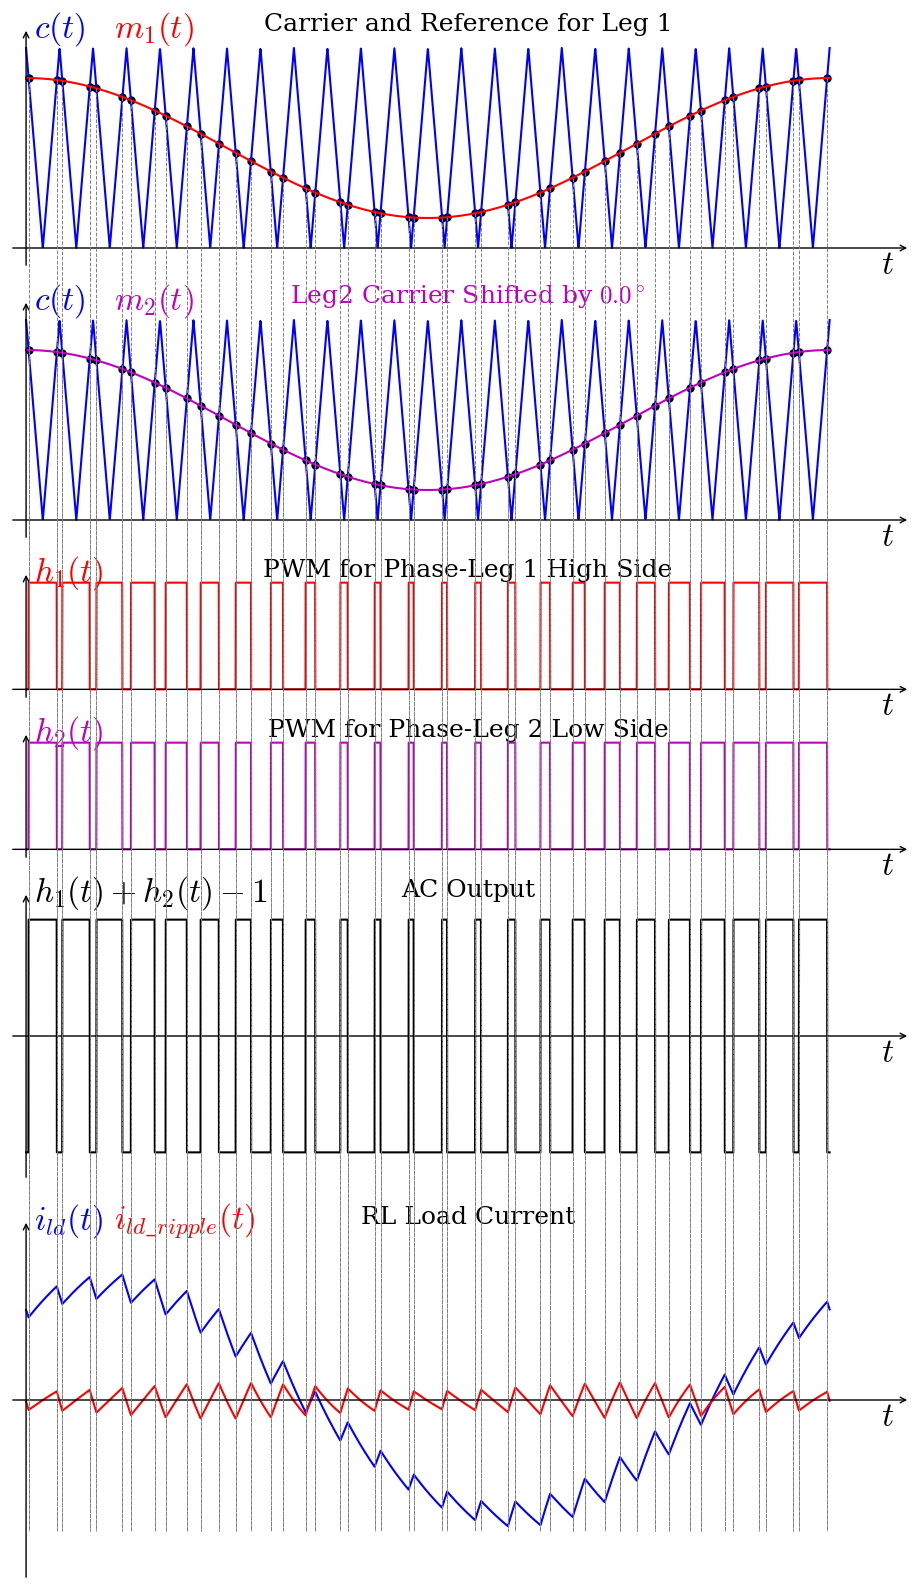

In [33]:
import matplotlib
from os import linesep
from numpy import linspace,cos,pi,sin,random,arccos,heaviside,array,fft,abs, angle,sqrt
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from matplotlib import animation,rc
rc('animation', html='jshtml')
plt.rcParams.update({"font.family" : "serif","mathtext.fontset" : "cm"})

#functions
def carr(f,theta,t): #carrier
  return 1/pi*arccos(cos(2*pi*f*t+theta))

def m(MI,f,theta,t): #modulation function
  return (MI*cos(2*pi*f*t + theta) + 1)/2

def h(ct,mt): #PWM switching function
  return heaviside(mt-ct,0)

#harmonic circuit analysis: returns current fft for voltage fft & impedance
def hca(vfft,Z):
  ild_fft=[] #load current fft
  for k in range(len(vfft)):
    ild_fft.append(vfft[k]/(Z[0] + 1j*Z[1]*k))
  return ild_fft

# define the function to be solved
def y(x,*data):
  MI,fm,theta_m,fc,theta_c = data
  return m(MI,fm,theta_m,x) -carr(fc,theta_c,x)

#solving for intersection points
def intersectionPoints(MI,fm,theta_m,fc,theta_c):
  ts=[] #list for intersection points
  for k in range(fc):
    ts.append(fsolve(y,1/fc*(0.25+k),args=(MI,fm,theta_m,fc,theta_c))[0])
    ts.append(fsolve(y,1/fc*(0.75+k),args=(MI,fm,theta_m,fc,theta_c))[0])
  ts=array(ts)
  mts = m(MI,fm,theta_m,ts) # m(t) values at intersection points
  return ts,mts

# draw dotted line between two sets of points in two different plots
def l2Ax(fig,ax1,ax2,ps1,ps2,color):
  line_set = []
  transFigure = fig.transFigure.inverted()
  for k in range(len(ps1[0])):
    p1 = transFigure.transform(ax1.transData.transform([ps1[0][k],ps1[1][k]]))
    p2 = transFigure.transform(ax2.transData.transform([ps2[0][k],ps2[1][k]]))
    line = matplotlib.lines.Line2D((p1[0],p2[0]),(p1[1],p2[1]),
                      transform=fig.transFigure,ls='--',color=color, lw=0.7)
    fig.lines.append(line)
  return

#parameters
Nf = 36 # number of frames
Np = 4096 # number of points
MI = 0.7 # modulation index
fm = 1 # modulation frequency
theta_m=0 #modulation phase angle
fc = 24*fm # carrier frequency
theta_c=pi #carrier phase angle
theta_cv = linspace(theta_c,theta_c+pi,Nf+1) #varying carrier angle for leg2
Zld = 1 # load impedance
pf = 0.8 # load power factor
Rld = Zld*pf #load resistance
Xld = Zld*(1 - pf**2)**.5 #load reactance at fundamental frequency

#time series
t = linspace(0,1,Np)
ct1 = carr(fc,theta_c,t) #carrier time-domain signal for leg1
mt1 = m(MI,fm,theta_m,t)    #modulation function time series for leg1
ht1 = h(ct1,mt1) #pwm signal time series for leg1
mt2 = mt1    #modulation function time series for leg2 the same as leg1

#spectrum and frequency series
fser = linspace(0,1,int(fc*8)+1) #frequency series for plotting

#intersection points
ts1,mts1 = intersectionPoints(MI,fm,theta_m,fc,theta_c)    #leg 1

#set up figures
fig = plt.figure(figsize=(9,16))
fig.tight_layout()
ax_frame = [[[0, .82, 1, .15], [-.02,1.1], [-.1, 1.1]], #sine1 & triangle
            [[0, .65, 1, .15], [-.02,1.1], [-.1, 1.1]], #sine2 & triangle
            [[0, .55, 1, .08], [-.02,1.1], [-.1, 1.1]], # pwm - leg1
            [[0, .45, 1, .08], [-.02,1.1], [-.1, 1.1]], # pwm - leg2
            [[0, .25,  1, .18], [-.02,1.1], [-1.1*1.125,1.1*1.125]], # ac output
            [[0, 0,  1, .225], [-.02,1.1], [-1.1,1.1]], # load current
            ]# [pos-boundary, xlim, ylim] for subplots
ax_lbl=[[['$c(t)$','$m_1(t)$'], '$t$'],
        [['$c(t)$','$m_2(t)$'], '$t$'],
        [['$h_1(t)$'], '$t$'],
        [['$h_2(t)$'], '$t$'],
        [['$h_1(t)+h_2(t)-1$'], '$t$'],
        [['$i_{ld}(t)$','$i_{ld\_ripple}(t)$'], '$t$'],
        ] #yx axes labels
title_lst = ['Carrier and Reference for Leg 1',
             'Carrier and Reference for Leg 2',
             'PWM for Phase-Leg 1 High Side',
             'PWM for Phase-Leg 2 Low Side',
             'AC Output',
             'RL Load Current',]
clst=[['b','r'], ['b','m'], ['r'],['m'],['k'],['b','r']] #colors of lines
ax_lst=[] #axis list or the list of subplots
tx_lst=[]
lines = [] #array for all lines
for k in range(len(ax_frame)):
  xn,xm,yn,ym = ax_frame[k][1]+ax_frame[k][2]
  ax=fig.add_axes(ax_frame[k][0],xlim=[xn,xm], ylim=[yn,ym],fc='none') #no fc
  ax.axis('off') #turn off axis frames
  ax_lst.append(ax)
  ax.annotate("", (xm, 0), (xn, 0),arrowprops={'arrowstyle':"->"}) #x-axis
  ax.annotate("", (0,ym), (0,yn),arrowprops={'arrowstyle':"->"}) #y-axis
  if k<=1:
    lines.append(ax.plot([], [], color='k', ls='',marker='o',markersize=5)[0]) #intersection points
  for kk in range(len(ax_lbl[k][0])):
    lines.append(ax.plot([], [], clst[k][kk], lw=1.5)[0]) # lines to plot
    ax.text(0.01+0.1*kk,ym,ax_lbl[k][0][kk],size=24,va='center',color=clst[k][kk]) #y labels
  ax.text(xm-.02,0,ax_lbl[k][1],size=24,va='top',ha='right') #x-axis label
  tx_lst.append(ax.text(0.55,ax_frame[k][2][1]+0.02,title_lst[k],color='k',
                        va='center',ha='center',size=18))

# animation function. This is called sequentially
def animate(i):
  ct2 = carr(fc,theta_cv[i],t) #carrier time-domain signal for leg2
  ht2 = h(ct2,mt2) #pwm signal time series for leg2
  ts2,mts2 = intersectionPoints(MI,fm,theta_m,fc,theta_cv[i]) #leg 2
  ht12 = ht1+ht2-1
  h12fft = fft.rfft(ht12) #spectrum of ac voltage
  ildfft = hca(h12fft,[Rld,Xld]) #spectrum of load current
  ild = fft.irfft(ildfft) #load current in time domain
  ild_ripple = ild - abs(ildfft[1]/len(ildfft))*cos(2*pi*fm*t+angle(ildfft[1]))
  lines[0].set_data(ts1, mts1) #intersetion points for leg1
  lines[1].set_data(t,ct1)
  lines[2].set_data(t,mt1)
  lines[3].set_data(ts2, mts2) #intersetion points for leg2
  lines[4].set_data(t,ct2)
  lines[5].set_data(t,mt2)
  lines[6].set_data(t,ht1) #leg1 switching function
  lines[7].set_data(t,ht2) #leg2 switching function
  lines[8].set_data(t,ht12) #ac voltage
  lines[9].set_data(t,ild) #load current
  lines[10].set_data(t,ild_ripple) #load current ripple
  fig.lines.clear() #clear lines of previous frame
  l2Ax(fig,ax_lst[0],ax_lst[5],[ts1,mts1],[ts1,0*ts1-.8],'gray') #dotted lines from intersections to pwm for leg1
  l2Ax(fig,ax_lst[1],ax_lst[5],[ts2,mts2],[ts2,0*ts2-.8],'gray') #dotted lines from intersections to pwm for leg2
  tx_lst[1].set_text('Leg2 Carrier Shifted by $' +str(round((theta_cv[i]-theta_c)/pi*180,1)) +'^\circ $')
  tx_lst[1].set_color('m')
  return

anim = animation.FuncAnimation(fig, animate, frames=Nf+1, interval=50)
# anim #uncomment to generate animation in the output area
# to save the animation, uncomment the following three lines
fn = r"PWM_RL_SingleRef.mp4"
writervideo = animation.FFMpegWriter(fps=2)
anim.save(fn, writer=writervideo,dpi = 120)